In [1]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import copy
%matplotlib inline

from subprocess import call
from lxml import etree
import inspect
import subprocess

import shutil
import glob
from backports import tempfile

from tempfile import mkstemp
from os import fdopen, remove

In [3]:
os.getcwd()

'C:\\Users\\teres\\Documents\\MasterThesis\\Final_Run_EMA\\Model_2015_2050'

## Main Functions

#### Change suitability uncertainty

Due to the time limitation of my research, the codes are not written in an effective way and I'm sure you could find a smarter way to construct this function and make it more extensible  :)

In [4]:
def change_suitability(geoproj_infile, geoproj_outfile, new_suitability_agri, 
                       new_suitability_gh,new_suitability_min,
                       new_suitability_pa,new_suitability_comm,
                       new_suitability_rl, new_suitability_rm,
                       new_suitability_rh,new_suitability_rec):
    source=open(geoproj_infile)
    tree = etree.parse(source)
    root = tree.getroot()
   
    ## Change agriculture suitability
    modelBlocks_1 = root[2][1][3][0][0][3][0][6][0][1][0][1][0]
    for i, node1 in enumerate(modelBlocks_1):
        node1.text = str(new_suitability_agri[i])
        
    ## Change greenhouses suitability   
    modelBlocks_2 = root[2][1][3][0][0][3][0][6][0][1][0][2][0]
    for j, node2 in enumerate(modelBlocks_2):
        node2.text = str(new_suitability_gh[j])
    
    ## Change mineral suitability
    modelBlocks_3 = root[2][1][3][0][0][3][0][6][0][1][0][3][0]
    for k, node3 in enumerate(modelBlocks_3):
        node3.text = str(new_suitability_min[k]) 
        
    ## Change public amenity suitability
    modelBlocks_4 = root[2][1][3][0][0][3][0][6][0][1][0][4][0]
    for l, node4 in enumerate(modelBlocks_4):
        node4.text = str(new_suitability_pa[l])
        
    ## Change commercial suitability
    modelBlocks_5 = root[2][1][3][0][0][3][0][6][0][1][0][5][0]
    for m, node5 in enumerate(modelBlocks_5):
        node5.text = str(new_suitability_comm[m]) 
         
    ## Change residential(l) suitability
    modelBlocks_6 = root[2][1][3][0][0][3][0][6][0][1][0][6][0]
    for n, node6 in enumerate(modelBlocks_6):
        node6.text = str(new_suitability_rl[n])    
    
    ## Change residential(M) suitability
    modelBlocks_7 = root[2][1][3][0][0][3][0][6][0][1][0][7][0]
    for o, node7 in enumerate(modelBlocks_7):
        node7.text = str(new_suitability_rm[o])   
        
    ## Change residential(H) suitability
    modelBlocks_8 = root[2][1][3][0][0][3][0][6][0][1][0][8][0]
    for p, node8 in enumerate(modelBlocks_8):
        node8.text = str(new_suitability_rh[p])           
        
    ## Change recreation suitability
    modelBlocks_9 = root[2][1][3][0][0][3][0][6][0][1][0][9][0]
    for q, node9 in enumerate(modelBlocks_9):
        node9.text = str(new_suitability_rec[q])      
        
    ##save file
    f = open(geoproj_outfile, 'w')
    f.write(etree.tostring(root, pretty_print=False, encoding='unicode'))
    f.close()

##### Change demand uncertainty

In [5]:
def _demand_helper(root):
    #read simulation starttime and endtime
    modelBlocks = root.xpath("/GeonamicaSimulation/model/modelSettings/startTime")
    simulation_starttime = modelBlocks[0].text
    modelBlocks = root.xpath("/GeonamicaSimulation/applicationSettings/SimulationPauses//elem")
    simulation_endtime = modelBlocks[0].text
    
    #check if demand is available at simulation endtime
    all_demands_time = []
    modelBlocks = root.xpath("//modelBlock[@name='MB_Land_use_demand']//value")
    for node in modelBlocks:
        all_demands_time.append(node.attrib.values()[0])
    if simulation_endtime in all_demands_time: #if endtime demand is available, use it
        demand_time = simulation_endtime
    else: #otherwise, use starttime
        demand_time = simulation_starttime
        
    return demand_time

def edit_demand(geoproj_infile, geoproj_outfile, new_demands):
    '''
    version 1.0
    - Modify demand at end of simulation time
    - If demand has not yet been specified after the Metronamica model is setup, create demand at endtime
    '''

    root = etree.parse(geoproj_infile)
    
    #check if demand is available at simulation endtime
    demand_time = _demand_helper(root)
    
    #read actual simulation endtime
    modelBlocks = root.xpath("/GeonamicaSimulation/applicationSettings/SimulationPauses//elem")
    simulation_endtime = modelBlocks[0].text
    
    #if demand for simulation endtime is already available, modify it
    if demand_time == simulation_endtime:
        modelBlocks = root.xpath("//modelBlock[@name='MB_Land_use_demand']//value[@time='{}']//elem".format(demand_time))
        for i, node in enumerate(modelBlocks):
            node.text = str(new_demands[i])
        #else, make new demand at simulation endtime
    else:
        modelBlocks = root.find("//modelBlock[@name='MB_Land_use_demand']/DemandBlock/LanduseDemands")
        
        for c in root.findall("//modelBlock[@name='MB_Land_use_demand']/DemandBlock/LanduseDemands/value"):
            dupe = copy.deepcopy(c)
            modelBlocks.append(dupe)
        
        modelBlocks = root.xpath("//modelBlock[@name='MB_Land_use_demand']/DemandBlock/LanduseDemands/value")
        print(simulation_endtime)
        for i, node in enumerate(modelBlocks):
            
            if i==1:
                node.attrib['time']=simulation_endtime
            print(node.attrib)
                
        modelBlocks = root.xpath("//modelBlock[@name='MB_Land_use_demand']//value[@time='{}']//elem".format(simulation_endtime))
        for i, node in enumerate(modelBlocks):
            node.text = str(new_demands[i])
                
        
    #save file
    f = open(geoproj_outfile, 'w')
    f.write(etree.tostring(root, pretty_print=False, encoding='unicode'))
    f.close()

In [4]:
def _generate_options(log_option='cmd_log.xml', 
                      run_option='Run', 
                      step_nr = 0,
                      save=None,
                      model_folder = os.getcwd()):
    if run_option == 'Step':
        run_option = ['--Step', str(step_nr)]
    else:
        run_option = ['--Run']
    
    if save:
        save_option = ['--Save']
    else:
        save_option = []
        
    if log_option:
        log_option = model_folder+'\\'+log_option
        
        #change the directory where land-use maps are logged
        with open(log_option, 'rb') as xml_file:
            root = etree.parse(xml_file)
        modelBlocks = root.xpath("//Path")
        for node in modelBlocks:
            node.text=model_folder+'\\Log_cmd'
        f = open(log_option, 'w')
        f.write(etree.tostring(root, pretty_print=False, encoding='unicode'))
        f.close()
        
        del root
        del f
        
        log_option = [ '--LogSettings', log_option]
    else:
        log_option = []
        
    return run_option, save_option, log_option

In [14]:
#log_option = r'C:\Users\teres\Documents\MasterThesis\EMA_Metronamica\mra_2006\cmd_log.xml'

In [5]:
def run_model(geoproj, 
              log_option='cmd_log.xml', 
              run_option='Run',
              step_nr = 2,
              save=None,
              model_folder = os.getcwd()):
       
    all_phases: {'phase01': 'arg preparation phase', 
                 'phase99': 'simulation run'} 
    
        
    '''
    phase01: exe's arg preparation phase
    '''
    run_option, save_option, log_option = _generate_options(log_option, run_option, step_nr, save, model_folder)
        
    geoproj = model_folder+'\\'+geoproj
    '''
    phase99: simulation run
    '''
    
    #change directory to Metronamica's directory
    notebook_dir = os.getcwd()
    metronamica_dir = r"C:\Program Files (x86)\Geonamica/Metronamica/"
    assert os.path.isdir(metronamica_dir)
    os.chdir(metronamica_dir)
    #print(geoproj)


    #compose arguments for the executable
    arg_exe = ['GeonamicaCmd.exe']
    arg_exe.extend(run_option)
    arg_exe.extend(log_option)
    arg_exe.extend(save_option)
    arg_exe.extend([geoproj])
    
    #run the model
    call(arg_exe)
    #subprocess.run(arg_exe)
    #change back to original directory
    os.chdir(notebook_dir)

In [8]:
def metronamica_python_interface(geoproj,
                            new_suitability_agri=[],
                            new_suitability_gh=[],
                            new_suitability_min=[],
                            new_suitability_pa=[],
                            new_suitability_comm=[],
                            new_suitability_rh=[], 
                            new_suitability_rm=[],
                            new_suitability_rl=[],
                            new_suitability_rec=[],
                            new_suitability_na=[],
                            #new_demands= [],
                            log_option='cmd_log.xml', 
                            run_option='Run',
                            step_nr = 0,
                            save=None,
                            coupling=False,
                            model_folder = None):
        
    if model_folder != os.getcwd():
        #make temporary directory
        tempfolder = tempfile.TemporaryDirectory()
        model_folder = tempfolder.name + "\\metronamica_model"
        src = os.getcwd()
        dst = model_folder
        shutil.copytree(src, dst)
        
    geoproj_ = model_folder+"\\"+geoproj
    
# edit suitability
    change_suitability(geoproj_infile=geoproj_, 
                       geoproj_outfile=geoproj_,
                       new_suitability_agri=new_suitability_agri,
                       new_suitability_gh=new_suitability_gh,
                       new_suitability_min=new_suitability_min,
                       new_suitability_pa=new_suitability_pa,
                       new_suitability_comm=new_suitability_comm,
                       new_suitability_rh=new_suitability_rh,
                       new_suitability_rm=new_suitability_rm,
                       new_suitability_rl=new_suitability_rl,
                       new_suitability_rec=new_suitability_rec)
    
#edit demand
    #edit_demand(geoproj_infile=geoproj_,
                #geoproj_outfile=geoproj_,
                #new_demands=new_demands)

    if not coupling:
        #run model
        run_model(geoproj, log_option, run_option, step_nr, save, model_folder)
        #retrieve result
        output_folder = model_folder+'\\Log_cmd\\Land_use'
        output_maps = []
        for file in os.listdir(output_folder):
            output_maps.append(os.path.join(output_folder, file))
        result = np.loadtxt(output_maps[-1], skiprows=6)
        #result0= np.loadtxt(output_maps[0], skiprows=6)
        
    if model_folder != os.getcwd():
        tempfolder.cleanup()
        
    return result

### Test: can your python codes command the Metronamica model to run?
This cell below help you know if your codes successfully change the Metronamica values and "control" the Metronamica simultion.

Don't forget:
- to adapt "geoproj" to the location of your own metronamica model. 
- In my case, since there are four flooding probability categories for each land suitability parameter (no info, small, middle, high), I assign them each with a vector consisting of four values. For instance, for "new_suitability_agri", the 0.8 means the suitability value for agriculture land under small flooding probability is 0.8.
- Before executing this cell, if you are opening your Metronamica model via the Metronamica interface, click "reset" and close.

In [17]:
import datetime
print(datetime.datetime.now())

result = metronamica_python_interface(geoproj= 'mra_2050.geoproj',
                                 new_suitability_agri=[0.5,0.8,0.9,1],
                                 new_suitability_gh= [0.5,0.6,0.7,0.9],
                                 new_suitability_min= [0.5,0.7,0.9,1],
                                 new_suitability_pa= [0.5,0.2,0.4,0.8],
                                 new_suitability_comm= [0.5,0.1,0.3,0.8],
                                 new_suitability_rl= [0.5,0.2,0.4,0.8],
                                 new_suitability_rm= [0.5,0.1,0.3,0.8],
                                 new_suitability_rh= [0.5,0,0.2,0.7],
                                 new_suitability_rec= [0.5,0.7,0.8,0.9], 
                                 log_option='cmd_log.xml',
                                 run_option='Run',
                                 #step_nr = 1,
                                 save=False,
                                 model_folder= os.getcwd())

print(datetime.datetime.now())

2021-09-05 17:03:12.175873
2021-09-05 17:03:24.153522


In [12]:
import datetime
print(datetime.datetime.now())

result2 = metronamica_python_interface(geoproj= 'mra_2050.geoproj',
                                 new_suitability_agri=[0.5,0.9,0.9,1],
                                 new_suitability_gh= [0.5,0.7,0.8,1],
                                 new_suitability_min= [0.5,0.7,0.9,1],
                                 new_suitability_pa= [0.5,0.2,0.6,1],
                                 new_suitability_comm= [0.5,0.1,0.5,1],
                                 new_suitability_rl= [0.5,0.2,0.6,1],
                                 new_suitability_rm= [0.5,0.1,0.5,1],
                                 new_suitability_rh= [0.5,0,0.4,1],
                                 new_suitability_rec= [0.5,0.7,0.9,1], 
                                 log_option='cmd_log.xml',
                                 run_option='Run',
                                 #step_nr = 1,
                                 save=False,
                                 model_folder= os.getcwd())

print(datetime.datetime.now())

2021-09-04 19:26:27.396517
2021-09-04 19:26:39.048659


In [16]:
#cmap = sns.mpl_palette("Set3", 15)

In [13]:
from matplotlib.colors import ListedColormap

colors = {"white":1,"lightgreen":2,"indigo":3,"yellow":4, "blue":5, "lightcoral":6, "red":7, "brown":8, "pink":9, "green":10,
          "lightblue":11, "gray":12,"black":13, "khaki":0}
l_colors = sorted(colors, key=colors.get)
cMap = ListedColormap(l_colors)

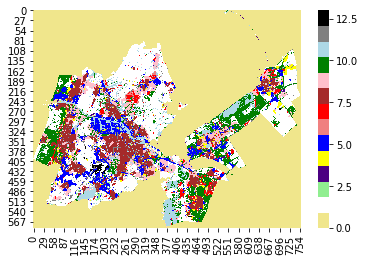

In [14]:
sns.heatmap(result, cmap = cMap)

The normal case: the initial land-use map of 2006

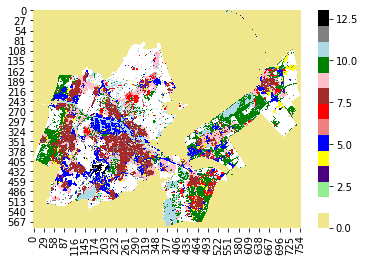

In [15]:
sns.heatmap(result2, cmap = cMap)

If you can see any differences between the two maps, congrats! This means you codes work and the results are different because you give them different suitability values in the two cases.

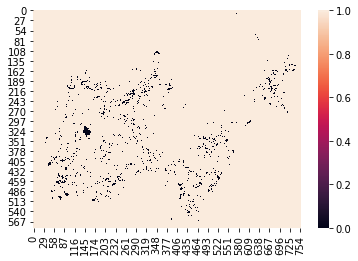

In [16]:
sns.heatmap(result ==result2)

### Connect Metronamica with EMA

In [9]:
    '''
    Prepare the model for 
    '''

def geonamica_dtag_ema(geoproj='mra_2050.geoproj', 
                       log_option='cmd_log.xml',
                       no_info = 0.5,
                       great_agri=0.8, mid_agri=0.9, small_agri=1,
                       great_gh=0.6, mid_gh=0.8, small_gh=1,
                       great_min=0.7, mid_min=0.9,small_min=1,
                       great_pa=0.2, mid_pa=0.6, small_pa=1,
                       great_comm=0.1, mid_comm=0.5, small_comm=1,
                       great_rl=0.2, mid_rl=0.6, small_rl=1,
                       great_rm=0.1, mid_rm=0.5, small_rm =1,
                       great_rh=0, mid_rh=0.4, small_rh=1,
                       great_rec=0.7, mid_rec=0.9, small_rec=1,  
                       model_folder= 'temp'):
    
    #generate the uncertain suitability parameters
    new_suitability_agri = [no_info, great_agri, mid_agri, small_agri]
    new_suitability_gh = [no_info, great_gh, mid_gh, small_gh]
    new_suitability_min = [no_info, great_min, mid_min, small_min]
    new_suitability_pa = [no_info, great_pa, mid_pa, small_pa]
    new_suitability_comm = [no_info, great_comm, mid_comm, small_comm]
    new_suitability_rl = [no_info, great_rl, mid_rl, small_rl]
    new_suitability_rm = [no_info, great_rm, mid_rm, small_rm]
    new_suitability_rh = [no_info, great_rh, mid_rh, small_rh]
    new_suitability_rec = [no_info, great_rec, mid_rec, small_rec]
    ##run simulation
    lu_map = metronamica_python_interface(geoproj=geoproj, 
                                        new_suitability_agri=new_suitability_agri,
                                        new_suitability_gh=new_suitability_gh ,
                                        new_suitability_min=new_suitability_min ,
                                        new_suitability_pa=new_suitability_pa ,
                                        new_suitability_comm=new_suitability_comm ,
                                        new_suitability_rh=new_suitability_rh ,
                                        new_suitability_rm=new_suitability_rm ,
                                        new_suitability_rl=new_suitability_rl,
                                        new_suitability_rec=new_suitability_rec ,
                                        log_option=log_option, 
                                        model_folder=model_folder)
    dummy = np.max(lu_map)
    
    return lu_map, dummy
    

 Note: the inputs for tfg, uncertainties will be changed once the uncertainty ranges are determined.

In [10]:
from ema_workbench import (Model, RealParameter, IntegerParameter, ScalarOutcome, Constant, TimeSeriesOutcome)

from ema_workbench.em_framework.outcomes import ArrayOutcome

#instantiate the model
lake_model = Model('lakeproblem', function=geonamica_dtag_ema)

#specify uncertainties
lake_model.uncertainties = [#RealParameter('great_agri',0.8, 1),
                    RealParameter('mid_agri',0.8, 0.9),
                    RealParameter('small_gh',0.8, 1),
                    #RealParameter('great_min', 0.7, 1),
                    RealParameter('mid_min', 0.7,0.9),
                    RealParameter('small_min', 0.9, 1),
                    #RealParameter('great_pa', 0.2,1),
                    RealParameter('mid_pa', 0.2,0.6),
                    RealParameter('small_pa', 0.6,1),
                    #RealParameter('great_comm', 0.1, 1),
                    RealParameter('mid_comm',  0.1, 0.5),
                    RealParameter('small_comm', 0.5,1),
                    #RealParameter('great_rl', 0.2,1),
                    RealParameter('mid_rl',0.2, 0.6),
                    RealParameter('small_rl',0.6,1),                    
                    #RealParameter('great_rm', 0, 0.4),
                    RealParameter('mid_rm', 0.1,0.5),
                    RealParameter('small_rm', 0.5, 1),
                    #RealParameter('great_rh', 0,0.4),
                    RealParameter('mid_rh', 0, 0.4),
                    RealParameter('small_rh',0.4, 1),
                    #RealParameter('great_rec',0.5, 0.9),
                    RealParameter('mid_rec', 0.7, 0.9),
                    RealParameter('small_rec', 0.9, 1)] 
#specify outcomes 
lake_model.outcomes = [ArrayOutcome('lu_map')]

C:\ProgramData\Anaconda3\lib\site-packages\ema_workbench\em_framework\optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)


#### Testing
Just run 5 experiments to test the connection of ema and metronamica

In [33]:
from ema_workbench import Policy, perform_experiments
from ema_workbench import ema_logging
import datetime
print(datetime.datetime.now())

ema_logging.log_to_stderr(ema_logging.INFO)

n_scenarios = 5
results = perform_experiments(lake_model, n_scenarios)

print(datetime.datetime.now())

[MainProcess/INFO] performing 5 scenarios * 1 policies * 1 model(s) = 5 experiments
[MainProcess/INFO] performing experiments sequentially


2021-09-04 19:50:44.194902


[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] 2 cases completed
[MainProcess/INFO] 3 cases completed
[MainProcess/INFO] 4 cases completed
[MainProcess/INFO] 5 cases completed
[MainProcess/INFO] experiments finished


2021-09-04 19:51:46.769211


In [34]:
experiments_t, outcomes_t = results

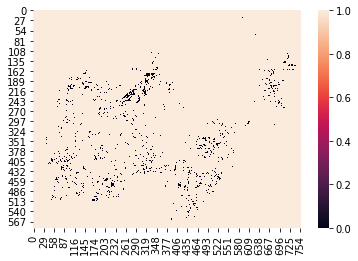

In [35]:
sns.heatmap(outcomes_t['lu_map'][0]==outcomes_t['lu_map'][4])

### Experiments

In [20]:
from ema_workbench import Policy, perform_experiments
from ema_workbench import ema_logging
from ema_workbench import save_results

In [37]:
import datetime
print(datetime.datetime.now())

ema_logging.log_to_stderr(ema_logging.INFO)

n_scenarios = 1400
results = perform_experiments(lake_model, n_scenarios)
save_results(results, "exp_1400_new.tar.gz")

print(datetime.datetime.now())

[MainProcess/INFO] performing 1400 scenarios * 1 policies * 1 model(s) = 1400 experiments
[MainProcess/INFO] performing experiments sequentially


2021-09-04 20:21:22.531693


[MainProcess/INFO] 140 cases completed
[MainProcess/INFO] 280 cases completed
[MainProcess/INFO] 420 cases completed
[MainProcess/INFO] 560 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 840 cases completed
[MainProcess/INFO] 980 cases completed
[MainProcess/INFO] 1120 cases completed
[MainProcess/INFO] 1260 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] results saved successfully to C:\Users\Administrator\Documents\Final_Run_EMA - New\Model_2015_2050\exp_1400_new.tar.gz


2021-09-05 01:16:41.786614


### Load results

In [11]:
from ema_workbench.util.utilities import load_results

results_1= load_results('exp_1400_new.tar.gz')
experiments_1, outcomes_1 = results_1

In [12]:
results_2= load_results('exp_new_600.tar.gz')
experiments_2, outcomes_2 = results_2

In [15]:
#experiments = pd.concat([experiments_1, experiments_2])

### Prepare the data for further analysis: Kappa Calculation

In [13]:
from lxml import etree
import pandas as pd
import numpy as np
import os
import sys
from subprocess import call, Popen, check_output
from lxml import etree
from PIL import Image

In [14]:
import Kappa_1 as Kappa

In [15]:
from importlib import reload
Kappa = reload(Kappa)

In [16]:
mask = np.array(Image.open('regionboundary_extents_of_landuse.tif'))

In [17]:
mask_1 = mask[:-1,:]

In [18]:
ooi = outcomes_1['lu_map'].astype(int)

In [19]:
np.shape(ooi)

(1400, 584, 757)

In [19]:
ooi_2 = np.vstack((ooi, outcomes_2['lu_map'].astype(int)))

In [21]:
np.shape(ooi_2)

(2000, 584, 757)

In [20]:
total_cells = Kappa.calc_total_cells(mask_1)

In [23]:
np.shape(mask_1)

(584, 757)

In [24]:
np.unique(mask_1, return_counts=True)[-1][-1]

177988

In [21]:
total_cells

177988

In [101]:
np.shape(ooi_2[-1])

(584, 757)

In [22]:
from importlib import reload
Kappa = reload(Kappa)

In [23]:
import datetime
print(datetime.datetime.now())

Kappa_df = Kappa.kappa_ema_multiprocess(ooi_2, mask_1)
print(datetime.datetime.now())

2021-09-05 17:25:49.830927
number of iteration will be 201
iteration no 1
iteration no 2
iteration no 3
iteration no 4
iteration no 5
iteration no 6
iteration no 7
iteration no 8
iteration no 9
iteration no 10
iteration no 11
iteration no 12
iteration no 13
iteration no 14
iteration no 15
iteration no 16
iteration no 17
iteration no 18
iteration no 19
iteration no 20
iteration no 21
iteration no 22
iteration no 23
iteration no 24
iteration no 25
iteration no 26
iteration no 27
iteration no 28
iteration no 29
iteration no 30
iteration no 31
iteration no 32
iteration no 33
iteration no 34
iteration no 35
iteration no 36
iteration no 37
iteration no 38
iteration no 39
iteration no 40
iteration no 41
iteration no 42
iteration no 43
iteration no 44
iteration no 45
iteration no 46
iteration no 47
iteration no 48
iteration no 49
iteration no 50
iteration no 51
iteration no 52
iteration no 53
iteration no 54
iteration no 55
iteration no 56
iteration no 57
iteration no 58
iteration no 59
iterat

In [24]:
Kappa_df

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,1.000000,0.945943,0.940829,0.940768,0.945914,0.938394,0.939565,0.940379,0.944670,0.937210,...,0.936431,0.942675,0.944665,0.943154,0.939039,0.938092,0.940712,0.947192,0.948316,0.936765
1,0.945943,1.000000,0.942197,0.942996,0.943883,0.944958,0.942265,0.943190,0.943839,0.940166,...,0.938278,0.943128,0.944666,0.943121,0.941274,0.942671,0.943259,0.945813,0.945397,0.938231
2,0.940829,0.942197,1.000000,0.943161,0.941988,0.941363,0.944394,0.941697,0.942908,0.942808,...,0.937805,0.947268,0.941786,0.941566,0.941842,0.938945,0.944923,0.939701,0.939764,0.943820
3,0.940768,0.942996,0.943161,1.000000,0.936974,0.942453,0.941211,0.945243,0.939268,0.940263,...,0.933727,0.943447,0.937043,0.938501,0.946927,0.939959,0.941386,0.941151,0.940514,0.945181
4,0.945914,0.943883,0.941988,0.936974,1.000000,0.940053,0.941051,0.939283,0.945947,0.937384,...,0.941204,0.943744,0.947731,0.945319,0.936549,0.939695,0.944285,0.945528,0.944342,0.936905
5,0.938394,0.944958,0.941363,0.942453,0.940053,1.000000,0.940592,0.945054,0.939051,0.940775,...,0.936049,0.943848,0.939899,0.942252,0.940731,0.941983,0.939859,0.940692,0.941643,0.941656
6,0.939565,0.942265,0.944394,0.941211,0.941051,0.940592,1.000000,0.942514,0.939356,0.939873,...,0.938497,0.942605,0.940966,0.940510,0.942444,0.943453,0.945816,0.939533,0.938791,0.943334
7,0.940379,0.943190,0.941697,0.945243,0.939283,0.945054,0.942514,1.000000,0.938761,0.939847,...,0.934198,0.943793,0.938415,0.941435,0.945588,0.941935,0.940761,0.939902,0.940756,0.941774
8,0.944670,0.943839,0.942908,0.939268,0.945947,0.939051,0.939356,0.938761,1.000000,0.935821,...,0.935785,0.942327,0.943296,0.942535,0.935181,0.937175,0.942035,0.944200,0.943362,0.939532
9,0.937210,0.940166,0.942808,0.940263,0.937384,0.940775,0.939873,0.939847,0.935821,1.000000,...,0.942079,0.942476,0.938056,0.939716,0.938715,0.942519,0.941546,0.936734,0.937601,0.940805


In [25]:
Kappa_df.to_csv('kappa_2000.csv')

#### Create maps for the baseline scenario (no flooding considered)

In [19]:
def metronamica_python_interface_base(geoproj,
                            new_suitability_agri=[],
                            new_suitability_gh=[],
                            new_suitability_min=[],
                            new_suitability_pa=[],
                            new_suitability_comm=[],
                            new_suitability_rh=[], 
                            new_suitability_rm=[],
                            new_suitability_rl=[],
                            new_suitability_rec=[],
                            new_suitability_na=[],
                            #new_demands= [],
                            log_option='cmd_log.xml', 
                            run_option='Run',
                            step_nr = 0,
                            save=None,
                            coupling=False,
                            model_folder = None):
        
    if model_folder != os.getcwd():
        #make temporary directory
        tempfolder = tempfile.TemporaryDirectory()
        model_folder = tempfolder.name + "\\metronamica_model"
        src = os.getcwd()
        dst = model_folder
        shutil.copytree(src, dst)
        
    geoproj_ = model_folder+"\\"+geoproj
    
    if not coupling:
        #run model
        run_model(geoproj, log_option, run_option, step_nr, save, model_folder)
        #retrieve result
        output_folder = model_folder+'\\Log_cmd\\Land_use'
        output_maps = []
        for file in os.listdir(output_folder):
            output_maps.append(os.path.join(output_folder, file))
        result = np.loadtxt(output_maps[-1], skiprows=6)
        #result0= np.loadtxt(output_maps[0], skiprows=6)
        
    if model_folder != os.getcwd():
        tempfolder.cleanup()
        
    return result

In [20]:
import datetime
print(datetime.datetime.now())

result = metronamica_python_interface_base(geoproj= 'mra_2050 - baseline.geoproj',
                                 log_option='cmd_log.xml',
                                 run_option='Run',
                                 #step_nr = 1,
                                 save=False,
                                 model_folder= os.getcwd())

print(datetime.datetime.now())

2021-09-11 12:37:33.350078
2021-09-11 12:37:48.340268


### Not read from here
Use multiprocessing

In [ ]:
from ema_workbench import ema_logging, MultiprocessingEvaluator

ema_logging.log_to_stderr(ema_logging.INFO)

import datetime
print(datetime.datetime.now())

with MultiprocessingEvaluator(lake_model, n_processes=4) as evaluator:
    results = evaluator.perform_experiments(scenarios=10)
    
print(datetime.datetime.now())

2021-08-31 10:15:46.945961


[MainProcess/INFO] pool started
[MainProcess/INFO] performing 10 scenarios * 1 policies * 1 model(s) = 10 experiments
